In [28]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.stats import norm
import matplotlib as mpl
import timeit
import time 
import sys

%matplotlib inline
mpl.rc('figure', titlesize=35)
mpl.rc('axes', labelsize=18)
mpl.rc('axes', grid=True)
mpl.rc('grid', linestyle=':')
mpl.rc('legend', fontsize=15)
mpl.rc('figure', figsize=(10, 5.5), dpi=150)

%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


# Calcolo degli integrali con tecniche montecarlo

L'esercizio richiede di calcolare l'integrale
$$
\int_{0}^{+1} x^4 + x^5
$$
con tecniche montecarlo e di discutere di tecniche di riduzione della varianza. 
Per calcolare l'integrale si possono usare due tecniche:

## Media campioni
Si divide la regione di integrazione in N campioni e si calcola la media in questa maniera:
$$
I = \int_{a}^{b} f(x) dx  \approx (b - a) \frac{1}{N} \sum_{i=1}^{N} f(x_i)
$$
Nel limite di un numero di campioni molto grande
$$
\lim_{N \rightarrow +\infty} (b - a) \frac{1}{N} \sum_{i=1}^{N} f(x_i) = I
$$
$ x_1, x_2, x_N $ sono numeri distruibiti casualmente in modo uniforme lungo l'intervallo.
Si può osservare che
$$
<f> = \frac{1}{N} \sum_{i=1}^{N} f(x_i) \\
<f^2> = \frac{1}{N} \sum_{i=1}^{N} f^2(x_i) \\
Var(f) = <f^2> - <f>^2 \\
Var(I_m) = (b - a)^2 \frac{Var(f)}{N}
$$

## Hit or miss
In questo caso viene stabilito un numero di iterazioni N e viene salvata una variabile contatore N0 vengono generate due sequenze di N numeri casuali: una nell'intervallo $(a, b)$ e l'altra in $(min(f(x), max(f(x)))$. I punti generati vengono trattati come coordinate puntuali sugli assi cartesiani xy. Per ogni punto (x_i, y_i) viene calcolato f(x_i). Se 
$ |f(x_i)| < |y_i| $ allora N0 viene incrementato di un'unità.
Ripetendo il processo N volte per ogni punto generato viene calcolato l'integrale come
$$
I = Area  \frac{N0}{N} = (y_{max} - y_{min})(b - a) \frac{N0}{N} + y_{min} (b - a)
$$
N0 segue una distrubzione binomiale; di conseguenza:
$$
<N0> = Np \\
V[I] = \frac{1}{N}p(1-p)(b-a)^2(y_{max} - y_{min})^2 \\
\sigma(N0) = \sqrt{Np(1-p)}
$$
Con $p = N0/N$.

In [66]:
a = 0
b = 1

@jit
def func(x):
    return x**4 + x**5

@jit
def sample_mean(f, a, b, n):
    x = np.random.uniform(a, b, n)
    favg = np.mean(f(x))
    fsquareavg = np.mean(np.square(f(x)))
    fvar = fsquareavg - np.square(favg)
    integral = (b - a) * favg
    variance = 1 / n * (fsquareavg - favg**2)
    return integral, variance


@jit
def hit_or_miss(f, a, b, n):
    x = np.random.uniform(a, b, n)
    # Per fortuna ymax e ymin coincidono con i valori di
    # f valutati negli estremi a e b.
    ymax = func(b)
    ymin = func(a)
    x = np.random.uniform(a, b, n)
    y = np.random.uniform(ymin, ymax, n)
    fx = func(x)
    hits = y[np.abs(y) < np.abs(fx)]
    p = hits.size / n
    integral = p * (ymax - ymin) * (b - a)
    variance = 1 / n * p * (1 - p) * (b - a)**2 * (ymax - ymin)**2
    return integral, variance

In [67]:
n = np.logspace(2, 7, dtype=np.int32)
filla = np.full_like(n, a)
fillb = np.full_like(n, b)
fillf = [func for el in n]

p = Pool()

async_results_sample_mean = p.starmap_async(sample_mean, zip(fillf, filla, fillb, n))
results_sample_mean = np.array(async_results_sample_mean.get())

async_results_hit_or_miss = p.starmap_async(hit_or_miss, zip(fillf, filla, fillb, n))
results_hit_or_miss = np.array(async_results_hit_or_miss.get())

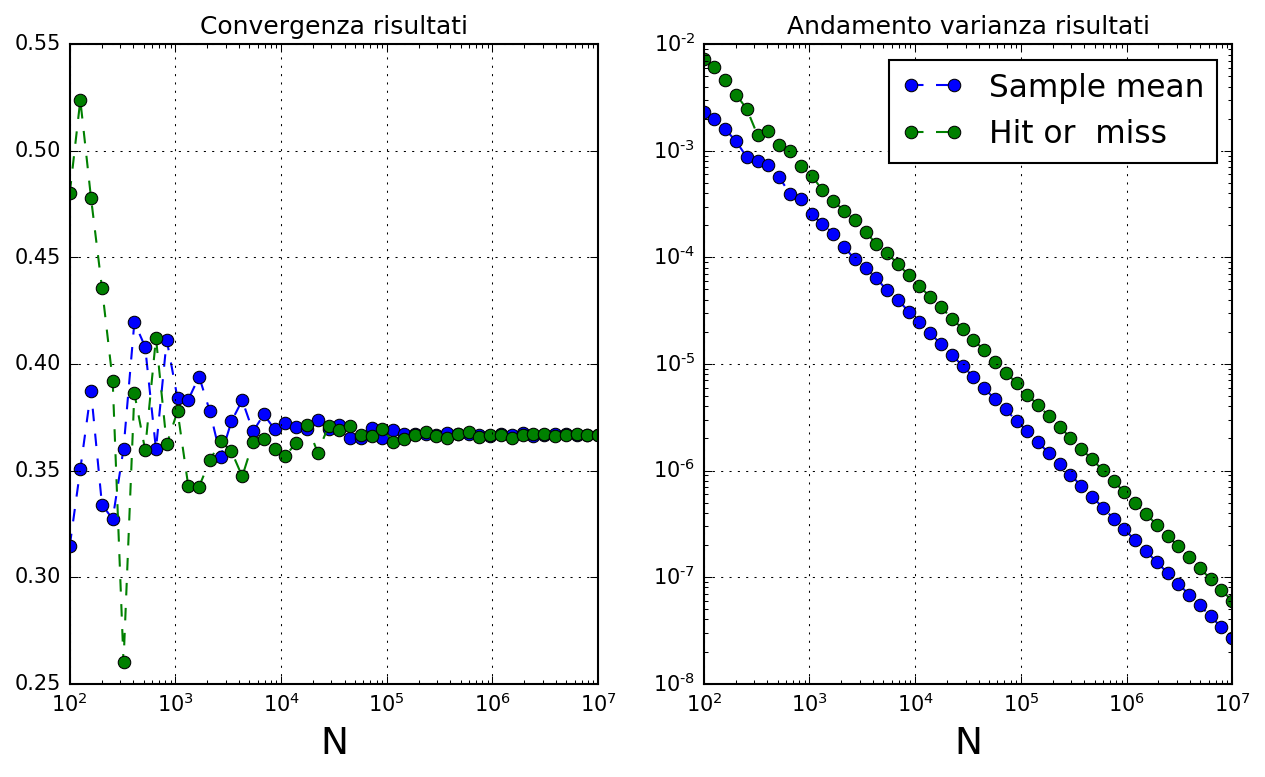

In [68]:
# Plot del andamento del risultato
fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].set_title('Convergenza risultati')
axs[0].set_xscale('log')
axs[0].set_xlabel('N')
axs[0].plot(n ,results_sample_mean[:, 0] , 'o--', label='Sample mean')
axs[0].plot(n ,results_hit_or_miss[:, 0] , 'o--', label='Hit or  miss')

axs[1].set_title('Andamento varianza risultati')
axs[1].set_xlabel('N')
axs[1].loglog(n ,results_sample_mean[:, 1] , 'o--', label='Sample mean')
axs[1].loglog(n ,results_hit_or_miss[:, 1] , 'o--', label='Hit or  miss')
axs[1].legend()

# Stratification

L'approccio della stratificazione consiste nel suddividere l'integrale in diverse regioni e di calcolare il risultato dell'integrale separatamente per ognuna di esse. L'integrale finale sarà la somma dei singoli integrali ed analogamente la varianza totale sarà la somma delle varianze. 
A seconda del tipo di integrale si può scegliere come dividere l'intervallo di integrazione.

In [69]:
sample_mean(func, a, b, 20000)

(0.3750604825447398, 1.3611286255619037e-05)

In [70]:
# this cell is for test purposes
intervals = np.linspace(a, b, 3)
lows = intervals[:-1]
highs = np.roll(intervals, -1)[:-1]
vsample_mean = np.vectorize(sample_mean)
fillf = [func for el in lows]
filln = np.full_like(lows, 1000, dtype=np.int32)
results = vsample_mean(fillf, lows, highs, filln)
results

(array([0.00897929, 0.36024428]), array([5.96060687e-07, 2.96388436e-04]))

In [71]:
def stratified_sampling(f, a, b, nregion, npoints):
    intervals = np.linspace(a, b, nregion)
    npoints_interval = int(npoints / nregion)
    lows = intervals[:-1]
    highs = np.roll(intervals, -1)[:-1]
    fillf = [f for el in lows]
    filln = np.full_like(lows, npoints_interval, dtype=np.int32)
    vsample_mean = np.vectorize(sample_mean)
    results = vsample_mean(fillf, lows, highs, filln)
    return np.array(results)

In [72]:
nregions = np.linspace(2, 20, 10, dtype=np.int32)
npoints = 1000000

filla = np.full_like(n, a)
fillb = np.full_like(n, b)
fillf = [func for el in n]
fillnpoints = np.full_like(n, npoints)
# p = Pool()
integrals = np.array([])
variances = np.array([])

for nregion in nregions:
    results = stratified_sampling(func, a, b, nregion, npoints)
    integral = np.sum(results[0])
    variance = np.sum(results[1])
    integrals = np.append(integrals, integral)
    variances = np.append(variances, variance)

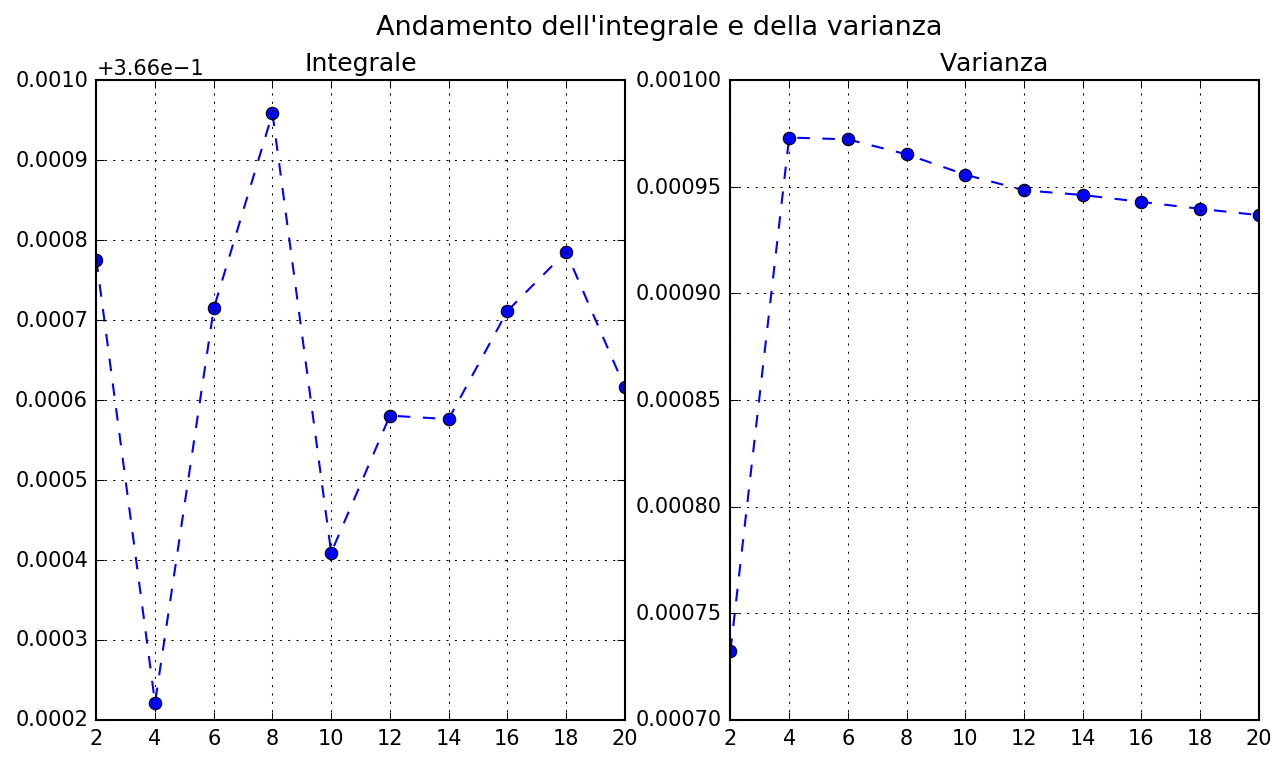

In [73]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(nregions, integrals, 'o--')
axs[0].set_title('Integrale')
axs[1].plot(nregions, np.sqrt(variances), 'o--')
axs[1].set_title('Varianza')
fig.suptitle('Andamento dell\'integrale e della varianza', fontsize=13);

Come si può osservare dalla grafico, La varianza tende ad aumentare anzichè a diminuire. Tale comportamento trova giustifazione nel fatto che la funzione ha un comportamento monotono crescente nell'intervallo di integrazione. Non è possibile trovare suddividere l'integrale in zone dove la funzione è più uniforme e il metodo non risulta quindi efficace.

# Importance sampling

L'importance sampling è un metodo che come suggerisce il nome utilizza un numero di campioni più elevato nelle zone in cui la funzione $y(x)$ è più "importante". Per utilizzare questo metodo è necessario conoscere o trovare una pdf  $g(x)$ normalizzata nell'intervallo $(a, b) $ tale che la quantità $y(x)/g(x)$ sia il più costante possibile. 
Utilizzando un cambio di variabili si può scrivere che:
$$
I = \int_a^b y(x) dx = \int_a^b \frac{y(x)}{g(x)} g(x)dx = \int_{G(a)}^{G(b)}\frac{y(x)}{g(x)} dG(x) dx \qquad G(x) := \int_a^b g(x) dx
$$

estraendo un campione $x$ appartenente ad una pdf $g(x)$ si può calcolare l'integrale sommando i contributi dei termini $y(x)/g(x)$.

Una funzione invertibile che approssima parzialmente il comportamento della funzione da integrare è la funzione $g(x) = 5x^4$

In [77]:
def g(x):
    return 5 * np.power(x, 4)

def invG(y):
    return np.power(y, 0.2)

def importance_sampling(a, b, N):
    unif = np.random.uniform(0, 1, N)
    x = invG(unif)
    gx = g(x)
    y = func(x) / g(x)
    ymean = np.mean(y)
    ysquare = np.square(y)
    integral = (b - a) * ymean
    variance = 1 / N * (np.mean(ysquare) - ymean**2)
    return integral, variance

In [78]:
n = np.logspace(2, 7, dtype=np.int32)
filla = np.full_like(n, a)
fillb = np.full_like(n, b)
fillf = [func for el in n]

p = Pool()

async_results_importance_sampling = p.starmap_async(importance_sampling, 
                                                    zip(filla, fillb, n))
results_importance_sampling = np.array(async_results_importance_sampling.get())

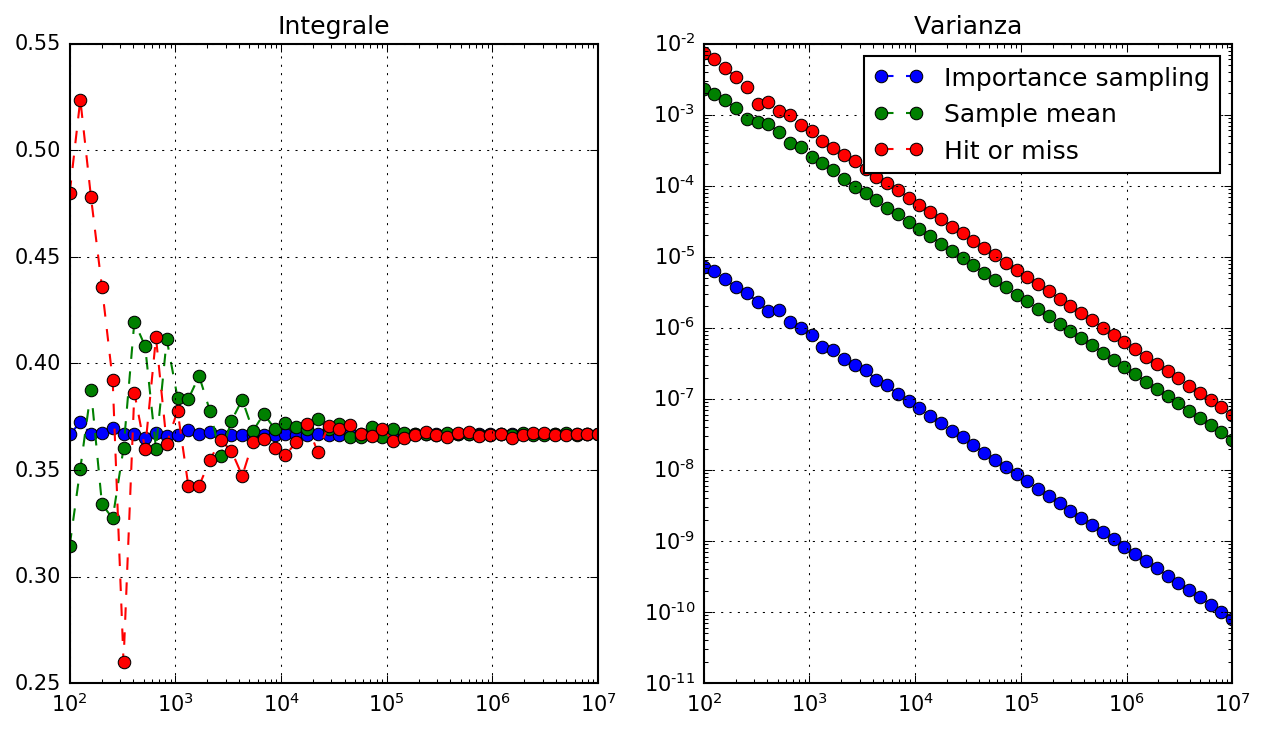

In [83]:
# Plot del andamento del risultato
fig, axs = plt.subplots(ncols=2, nrows=1)
axs[0].set_title('Integrale')
axs[0].set_xscale('log')
axs[0].plot(n, results_importance_sampling[:, 0] , 'o--', label="Importance sampling")
axs[0].plot(n, results_sample_mean[:, 0] , 'o--', label="Sample mean")
axs[0].plot(n, results_hit_or_miss[:, 0] , 'o--', label="Hit or miss")

axs[1].set_title('Varianza')
axs[1].loglog(n, results_importance_sampling[:, 1] , 'o--', label="Importance sampling")
axs[1].loglog(n, results_sample_mean[:, 1] , 'o--', label="Sample mean")
axs[1].loglog(n, results_hit_or_miss[:, 1] , 'o--', label="Hit or miss")
axs[1].legend(fontsize=12)

La figura mostra la convergenza dell'integrale e l'andamento della varianza al variare del numeri di campioni. Utilizzando il metodo dell'importance sampling si può ottenere una varianza di 3 ordini di grandezza minore rispetto alle tecniche di sample mean o di hit or miss.